In [181]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from skspatial.objects import LineSegment, Line, Vector

from enum import Enum

Layer = Enum("Layer", "FRONT BACK")

from helpers import *
from pcb_json import *

# Parameters 
edit those:

In [182]:
#####################################
# Track width and spacing
TRACK_WIDTH = 0.127 # 5mil
TRACK_SPACING = TRACK_WIDTH

TRACK_WIDTH = 0.1016 # 4mil
TRACK_WIDTH = 0.0889 # 3.5mil
TRACK_SPACING = 0.1016 # 4mil

TRACK_WIDTH = 0.1016 # 4mil
TRACK_SPACING = 0.127 # 5mil

#####################################
# other pcb parameters
LAYERS = 4

VIA_DIAM = 0.25
VIA_DRILL = 0.15

PIN_DIAM = 1.0 # this is for a 1.27mm pitch pin
PIN_DRILL = 0.65
SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw

# this is for the PCB connector - see https://www.farnell.com/datasheets/2003059.pdf
PAD_WIDTH = 3
PAD_HEIGHT = 2
PAD_PITCH = 2.5
PCB_EDGE_CUTS = False # draw on pcb outline

#####################################
# how to connect coils
PAD_ENABLE = False
CONNECT_WITH_VIAS = False

CONNECT_STAR_CENTER = False
CONNECT_STAR_VIAS = False

CONNECT_INSIDE = False
CONNECT_INSDE_VIAS_ONLY = True
CONNECT_OUTSIDE = False

#####################################
# FREEZE_01 courtyards:

# jog_min 15+ mm
# jog_max 52. mm

# smile_min = 20+ mm
# smile_max = 60. mm

#####################################
# Geometry RADIUS_
R_CENTER                    = 53 # this is kinda the main radius - try to make other dimensions depend on this

RADIUS_STATOR_HOLE          = 20 # 14
RADIUS_CONNECTIONS_INSIDE   = RADIUS_STATOR_HOLE + 3 * TRACK_SPACING # for connecting the bottoms of the coils
RADIUS_CONNECTIONS_INSIDE   = 30

RADIUS_COIL_START           = R_CENTER - 15
RADIUS_COIL_CENTER          = R_CENTER
RADIUS_COIL_CENTER_VIA      = R_CENTER + 0.5
RADIUS_COIL_END             = R_CENTER + 1

RADIUS_CONNECTIONS_OUTSIDE  = 53
RADIUS_CONNECTOR            = 54 + VIA_DIAM 

RADIUS_TOTAL_STATOR         = RADIUS_CONNECTOR + 2 * 2 * VIA_DIAM

CONNECT_VIAS_ANGLE_OFF_REL = 0.1
RADIUS_CONNECT_VIAS_OUTSIDE = 28

FILE_SUFFIX = f"_{round(R_CENTER)}_{round(RADIUS_TOTAL_STATOR)}mm.json"

#####################################
# NET Naming
COIL_NET_NAME = "/haptic_smile/coil"  
USE_INDIVIDUAL_NET_NAMES_PER_COIL = False # appends numbering to COIL_NET_NAME
USE_ABC_NET_NAMES_FOR_COILS = True # appends A,B,C to COIL_NET_NAME
    
#####################################
# which config
USE_ABC_MOTOR = False
USE_ARC = not USE_ABC_MOTOR
#####################################
if USE_ARC:
    ORIENT_ARC_ALL_SAME = True
    REMOVE_POINTS_FROM_TOP = 5
    NUM_SEGMENTS = 6 
    NUM_COILS = 20
    # 6/20*360 = 108 deg
    # design movement range = 80 deg - width of fader

    ROTATION = 360 - NUM_SEGMENTS/NUM_COILS/2*360 + (360/NUM_COILS/2) + 90
    ROTATION += -20
    FILE_NAME = f"freeze_01_coil_smile_" + FILE_SUFFIX

if USE_ABC_MOTOR:
    REMOVE_POINTS_FROM_TOP = 0
    NUM_SEGMENTS = 12
    NUM_COILS = 12
    FILE_NAME = f"coil_motor" + FILE_SUFFIX
    ROTATION = 0
#####################################
space = RADIUS_COIL_START * np.sin(np.deg2rad(360 / NUM_COILS / 2)) 
TURNS = int(space / (TRACK_SPACING+TRACK_WIDTH))

# TURNS -= 1 # leave some space for wires to pass from center between coils

#####################################
# meta helper
coil_windings_width = TURNS * (TRACK_WIDTH+TRACK_SPACING)
radius_coil_start_effective = round(RADIUS_COIL_START - coil_windings_width, 2)
radius_coil_end_effective = round(RADIUS_COIL_END + coil_windings_width,2)

print(f"Num Turns: {TURNS}")
print(f"Effective radius range: {radius_coil_start_effective} - {radius_coil_end_effective}")

Num Turns: 21
Effective radius range: 33.2 - 58.8


# Functions Definition for Coil Generation

In [183]:
def calculate_point(point, p_here, p_next, spacing, turn):
    vector = Vector(p_here) - Vector(p_next)
    normal = vector / np.linalg.norm(vector)
    normal = np.array([-normal[1], normal[0]])  # rotate 90 degrees

    reference_vector = Vector([-100, 0])
    angle = np.rad2deg(Vector(point).angle_between(reference_vector))
    if point[1] > 0:
        angle = 360 - angle

    # move the  point along the normal vector by the spacing
    offset = spacing * (turn * 360 + angle) / 360
    coil_point = point + normal * offset
    return (coil_point[0], coil_point[1])


def get_coil(template, turns, spacing):
    coil_points = []
    reference_vector = Vector([-100, 0])

    for turn in range(turns):
        for index in range(len(template)):
            p_here = template[index]
            turn_here = turn

            p_next = template[(index + 1) % len(template)]

            turn_here = turn
            turn_next = (turn * len(template) + index + 1) // len(template)

            coil_p_here = calculate_point(p_here, p_here, p_next, spacing, turn_here)
            coil_p_next = calculate_point(p_next, p_here, p_next, spacing, turn_next)

            if len(coil_points) >= 2:
                
                line1 = Line(
                    coil_points[-2],
                    np.array(coil_points[-1]) - np.array(coil_points[-2]),
                )
                # create a line from the two new points
                line2 = Line(
                    np.array(coil_p_here),
                    np.array(np.array(coil_p_here) - np.array(coil_p_next)),
                )

                # find the intersection of the two lines
                try:  # replace the previous point with the intersection
                    intersection = line1.intersect_line(line2)
                    coil_points[-1] = intersection
                except:  # the lines did not intersect so just add the points
                    coil_points.append(coil_p_here)

                coil_points.append(coil_p_next)
            else:
                coil_points.append(coil_p_here)
                coil_points.append(coil_p_next)

    return coil_points

def coil(template): 
    return get_coil(template, TURNS, TRACK_SPACING + TRACK_WIDTH)

def plot_points(points):
    df = pd.DataFrame(points, columns=["x", "y"])
    ax = df.plot.line(x="x", y="y", color="blue")

    scatter_df = pd.DataFrame(points, columns=["x", "y"])
    scatter_df.plot.scatter(x="x", y="y", color="red", ax=ax)

    ax.axis("equal")
    plt.grid(True)
    
    ax.text(0.05, 0.95, f"len= {len(points)}", transform=ax.transAxes, ha="left")


# Generate a single coil

with 2x2coils (2 in series: 2299 mm) and of those 2 in parallel resistance: 5.43 Ω
With a voltage of 5 V, the maximum current is 0.92 A


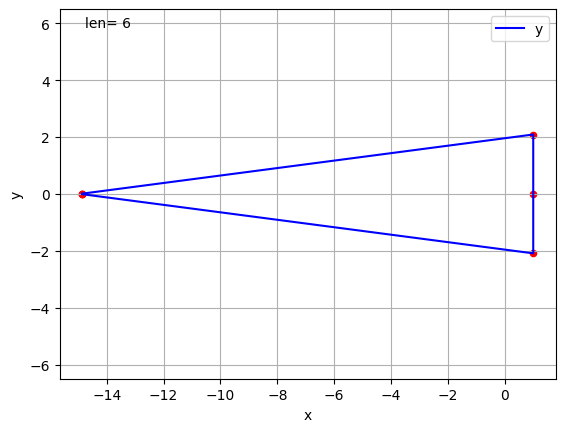

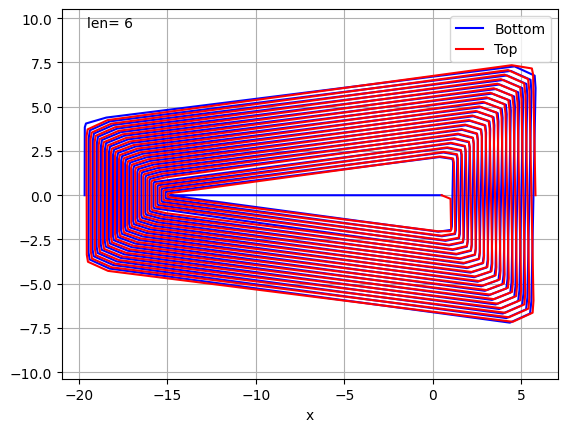

In [184]:

radius_len = RADIUS_COIL_END - RADIUS_COIL_START

angle = round(360/2/NUM_COILS,2)
y_amp = round(np.sin(np.deg2rad(angle)) * radius_len, 2)
x_len = round(np.cos(np.deg2rad(angle)) * radius_len, 2)

x_to = RADIUS_COIL_END - RADIUS_COIL_CENTER
x_from = x_to - x_len

# templates must be convex, simetric around the X axis and must include the center points on both size (e.g. (X1, 0).... (X2, 0) )
micro = 0.01 #1e-6
template = [
    (x_from, 0),
    (x_from, -micro),
    (x_to, -y_amp),
    (x_to, 0.0),
    (x_to, y_amp),
    (x_from, +micro)
]
# ########################################
# TODO parametric shape to template
shape = [
    (x_from+x_len/2,    -y_amp/2),
    (x_to,              -y_amp*0.8),
    (x_to,              0),
    (x_from+x_len/2,    +y_amp/2),
    (x_to,              +y_amp*0.8),
]
shape = [
    (x_to, -y_amp),
    (x_to, 0.0),
    (x_to, y_amp),
]
# template = shape
# template.insert(0, (x_from, 0))
# template.insert(1, (x_from, -micro))
# # # for i in range(len(shape)):
# # #     j = len(shape)-i-1
# # #     template.append([shape[j][0], -shape[j][1]])
# template.append((x_from, +micro))
if 1:
    # print(template)
    plot_points(template)
    # plot_points(optimize_points(coil(template)))
    # plot_points(chaikin_(coil(template), 5))

    temp_top = []
    for i in range(len(template)):
        temp_top.append(template[len(template) - i - len(template) // 2])
        # print(f"i = {i}, map = {len(template) - i - len(template) // 2}, template_f = {template_f[i]}")
    temp_top = flip_x(temp_top)

    CHAIKIN_ITERATIONS = 2
    points_top = chaikin_(flip_x(coil(temp_top)), CHAIKIN_ITERATIONS)
    points_bot = chaikin_(coil(template), CHAIKIN_ITERATIONS)

    # remove unnecessary points
    points_top = optimize_points(points_top)
    points_bot = optimize_points(points_bot)

    # add point to middle for via
    points_top = [(RADIUS_COIL_CENTER_VIA - RADIUS_COIL_CENTER, 0)] + points_top
    points_bot = [(RADIUS_COIL_CENTER_VIA - RADIUS_COIL_CENTER, 0)] + points_bot

    def plot_tracks_vias(track_points_top, track_points_bot, via_points=0):

        df = pd.DataFrame(track_points_bot, columns=["x", "y"])
        ax = df.plot.line(x="x", y="y", color="blue", label="Bottom")

        df = pd.DataFrame(track_points_top, columns=["x", "y"])
        df.plot.line(x="x", y="y", color="red", ax=ax, label="Top")

        if via_points:
            scatter_df = pd.DataFrame(via_points, columns=["x", "y"])
            scatter_df.plot.scatter(x="x", y="y", color="green", ax=ax)

        ax.axis("equal")
        plt.grid(True)
        ax.text(0.05, 0.95, f"len= {len(template)}", transform=ax.transAxes, ha="left")

    plot_tracks_vias(points_top, points_bot, 0)

# Compute Track Length, estimate resistance and print
def compute_track_length(points):
    track_length = 0
    for i in range(len(points) - 1):
        track_length += np.linalg.norm(np.array(points[i + 1]) - np.array(points[i]))
    return round(track_length,2)

def compute_pcb_track_resistance(length_mm, track_width_mm, copper_thickness_mm=0.035, resistivity=1.68e-8):
    cross_sectional_area_m2 = (track_width_mm / 1000.0) * (copper_thickness_mm / 1000.0)
    resistance_ohms = resistivity * (length_mm / 1000.0) / cross_sectional_area_m2
    return round(resistance_ohms,2)

length = compute_track_length(points_top+points_bot)
resistance = compute_pcb_track_resistance(length, TRACK_WIDTH)

#print(f"Result with 2coils in series: {round(length)} mm, resistance: {resistance} \u03A9")
resistance /= 2 #another pair of coils in parrallel
print(f"with 2x2coils (2 in series: {round(length)} mm) and of those 2 in parallel resistance: {resistance} \u03A9")

used_voltage = 5 # V
print(f"With a voltage of {used_voltage} V, the maximum current is {round(used_voltage / resistance,2)} A")

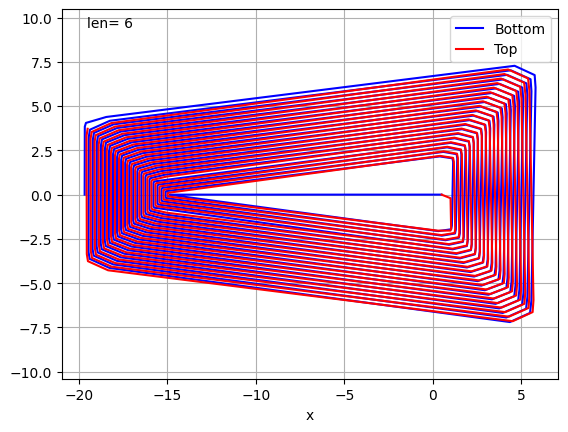

In [185]:

if 0: # iterate with this, disable and write number on top when found
    REMOVE_POINTS_FROM_TOP = 5
    plot_tracks_vias(points_top[:-REMOVE_POINTS_FROM_TOP], points_bot, 0)
else:
    # remove points from top so that both coils end in the same place
    if REMOVE_POINTS_FROM_TOP>0:
        points_top = points_top[:-REMOVE_POINTS_FROM_TOP]
    plot_tracks_vias(points_top, points_bot, 0)

# Reproduce coils

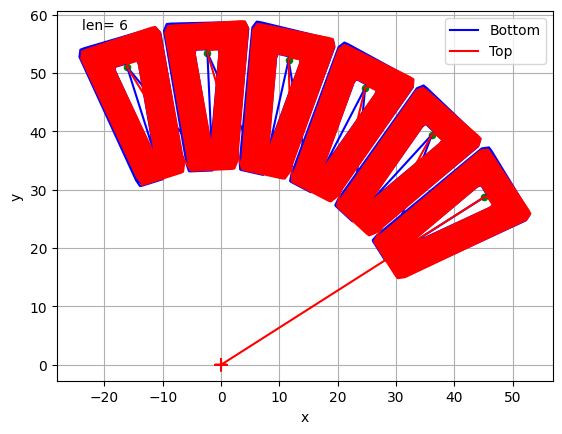

In [186]:
vias = []
tracks_top = []
tracks_bot = []
pads = []
pins = []
mounting_holes = []
silk = []
components = []

arc_seg = 360 / NUM_COILS

USE_LABELS = False #todo

def angleAt(coil_index):
    return coil_index * arc_seg + ROTATION

def place_coil(coil_points, angle, radius):
    return translate(rotate(coil_points, angle), radius, angle)

# def appendTo(tracks_obj, name, pts):
#     tracks_obj.append({"net": name, "pts": pts})

#array of points to draw a center crosshair:
tracks_top.append({
    "net": "cross", 
    "pts": [ 
        [0, -1], 
        [0, 1],
        [0,0],
        [-1, 0],
        [1, 0],
        [0,0]]
        })

# the main coils
coil_labels = ["A", "B", "C"]
coils_top = []
coils_bot = []
for i in range(NUM_SEGMENTS):
    angle = angleAt(i)
    radius = RADIUS_COIL_CENTER
    if ORIENT_ARC_ALL_SAME:
            coil_top = place_coil(points_top, angle, radius)
            coil_bot = place_coil(points_bot, angle, radius)
    else:
        if (i // 3) % 2 == 0:
            coil_top = place_coil(points_top, angle, radius)
            coil_bot = place_coil(points_bot, angle, radius)
        else:
            # slightly nudge the coils so that they don't overlap when flipped
            coil_top = place_coil(flip_y(points_top), angle, radius)
            coil_bot = place_coil(flip_y(points_bot), angle, radius)
        
    coils_top.append(coil_top)
    coils_bot.append(coil_bot)

    net_name = COIL_NET_NAME + "_"
    if USE_ABC_MOTOR:
        id_name = coil_labels[i % 3]
    else:
        id_name = str(NUM_SEGMENTS - i).zfill(2)
    net_name += id_name

    tracks_top.append({"net": net_name, "pts": coil_top})
    tracks_bot.append({"net": net_name, "pts": coil_bot})
    
    vias.append(create_via(pol2cat(angle, RADIUS_COIL_CENTER_VIA), id_name))
    silk.append(create_silk(pol2cat(angle, RADIUS_COIL_CENTER-1.5) , id_name))
    # silk.append(create_silk(pol2cat(angle, RADIUS_TOTAL_STATOR), id_name))
    # silk.append(create_silk(pol2cat(angle+1.5, radius_coil_end_effective+2), id_name))
    silk.append(create_silk(pol2cat(angle, radius_coil_end_effective+2), id_name))

if 1:
    via_points = []
    for via in vias:
        via_points.append([via["x"], via["y"]])

    track_points_top = []
    for t in tracks_top:
        for p in t["pts"]:
            track_points_top.append(p)

    track_points_bot = []
    for t in tracks_bot:
        for p in t["pts"]:
            track_points_bot.append([p[0], p[1]])
            
    plot_tracks_vias(track_points_top, track_points_bot, via_points)
        




# Create coil inner connections

In [187]:
# all ___At functions are little helpers that take coil_index + sometimes radius
def pointAt(coil_index, radius):
    return pol2cat(angleAt(coil_index), radius)

def netNameAt(coil_index):
    net_name = COIL_NET_NAME + "_"
    if USE_ABC_MOTOR:
        net_name += coil_labels[coil_index % 3]
    else:
        net_name += str(NUM_SEGMENTS - coil_index).zfill(2)
    return net_name

def appendAt(coils_ref, coil_index, radius):
    coils_ref[coil_index].append(pointAt(coil_index, radius))

def appendArc(tracks_ref, coil_index1, coil_index2, radius, name):
    tracks_ref.append({ 
        "net": name,
        "pts": draw_arc(angleAt(coil_index1), angleAt(coil_index2), radius)}) 

def appendViaWithName(coil_index, radius, name):
    vias.append(create_via(pointAt(coil_index, radius), name))

def appendVia(coil_index, radius):
    appendViaWithName(coil_index, radius, netNameAt(coil_index))
    


# connects coils with arc and uses last points of coils to connect to the arc
def connect_coils_auto_arc(c1, c2 , tracks_ref, radius):
    tracks_ref.append({
        "net": netNameAt(c1),
        "pts": (
            [coils_bot[c1][-1]]
            + draw_arc(angleAt(c1), angleAt(c2), radius)
            + [coils_bot[c2][-1]] )})     
    
def connect_coils_with_arc(c1, c2 , tracks_ref, radius, radius_points):
    pts = draw_arc(angleAt(c1), angleAt(c2), radius)

    if radius_points != 0:
        pts = [pointAt(c1, radius_points)] + pts + [pointAt(c2, radius_points)]

    tracks_ref.append({ "net": netNameAt(c1),"pts": pts}) 
    
    appendAt(coils_top, c1, radius)
    appendAt(coils_top, c2, radius)

    # append vias everywhere to connect middle layers properly in parallel.
    appendVia(c1, radius)
    appendVia(c2, radius)

if CONNECT_INSIDE: # create coil ic = inner connections

    radius_coni_common = RADIUS_CONNECTIONS_INSIDE - VIA_DIAM/2
    space = VIA_DIAM * 1.5

    radius_coni_A = radius_coni_common
    for c in range(0, NUM_COILS, 3):
        if c < NUM_SEGMENTS:
            point = pointAt(c, radius_coni_A)
            coils_bot[c].append(point)
            vias.append(create_via(point, netNameAt(c)))
    for con in range(2):
        connect_coils_auto_arc(con*6+0, con*6+3, tracks_top, radius_coni_A)
     
    radius_coni_B = radius_coni_common - 2 * space
    for c in range(1, NUM_COILS, 3):
        if c < NUM_SEGMENTS:
            point = pointAt(c, radius_coni_B)
            coils_bot[c].append(point)
            vias.append(create_via(point, netNameAt(c)))
    for con in range(2):
        connect_coils_auto_arc(con*6+1, con*6+4, tracks_bot, radius_coni_B)
        
    radius_coni_C = radius_coni_common - 1 * space
    for c in range(2, NUM_COILS, 3):
        if c < NUM_SEGMENTS:
            point = pointAt(c, radius_coni_C)
            coils_bot[c].append(point)
            vias.append(create_via(point, netNameAt(c)))
    for con in range(2):
        connect_coils_auto_arc(con*6+2, con*6+5, tracks_top, radius_coni_C)

### OUTSIDE CONNECTIONS
# ------------------------------------------------------------------------------------

if CONNECT_STAR_CENTER:
    r = RADIUS_CONNECTOR 
    connect_coils_with_arc(9, 11, tracks_top, r, 0)
    appendAt(coils_top, 10, r)
    appendVia(10, r)

elif CONNECT_STAR_VIAS:
    r = RADIUS_CONNECTOR 
    for i in range(9,NUM_COILS):
        if i < NUM_SEGMENTS:
            appendAt(coils_top, i, r)
            appendVia(i, r)
    
    def appArcViaName(coil_index, ci_, r):
        appendArc(tracks_top, coil_index, ci_, r, netNameAt(coil_index))
        appendViaWithName(ci_, r, netNameAt(coil_index))

    relative_offset = 1.0 - 0.06
    appArcViaName(9, 9+relative_offset, r)
    appArcViaName(11, 11-relative_offset, r)

if CONNECT_OUTSIDE:
    radius_cono_common = RADIUS_CONNECTIONS_OUTSIDE + VIA_DIAM
    space = VIA_DIAM * 1.5

    r = radius_cono_common + 1 * space
    connect_coils_with_arc(5, 8, tracks_bot, r, 0,)

    r = radius_cono_common + 2 * space
    connect_coils_with_arc(4, 7, tracks_bot, r, 0)

    r = radius_cono_common + 3 * space
    connect_coils_with_arc(3, 6, tracks_top, r, 0)

#  create the pads for connecting the inputs to the coils
if PAD_ENABLE:

    def appendSilk(y, text, size=1, angle=0):
        silk.append(create_silk((RADIUS_CONNECTOR - PAD_HEIGHT - 2.5, y), text, "f", 2.5, -900))

    appendSilk(+PAD_PITCH,   "C")
    appendSilk( 0,           "B")
    appendSilk(-PAD_PITCH,   "A")
    
    def appendPad(y, name):
        pads.append(create_pad([RADIUS_CONNECTOR, y], PAD_WIDTH, PAD_HEIGHT, "a", name))
    
    appendPad(+PAD_PITCH,   netNameAt(0))
    appendPad(0,            netNameAt(1))
    appendPad(-PAD_PITCH,   netNameAt(2))

    # connect coil A to the top pad
    pad_connection_point_x = RADIUS_CONNECTOR
    pad_angle = np.rad2deg(np.arcsin(PAD_PITCH / pad_connection_point_x))
    coils_top[0].append(pointAt(0, pad_connection_point_x))
    appendVia(0, pad_connection_point_x)

    # connect coil B to the middle pad
    coils_top[1].append((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0))
    vias.append(create_via(
            ((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0)), netNameAt(1)))
    
    # connect coil C to the bottom pad
    coils_top[2].append(pointAt(2, pad_connection_point_x))
    appendVia(2, pad_connection_point_x)

elif CONNECT_WITH_VIAS:
    r = RADIUS_CONNECTOR 
    for i in range(0,3):
        appendAt(coils_top[i], i, r)
        appendVia(i, r)

    def appArcViaName(coil_index, ci_, r):
        appendArc(tracks_top, coil_index, ci_, r, netNameAt(coil_index))
        appendViaWithName(ci_, r, netNameAt(coil_index))

    relative_offset = 1.0 - 0.06
    appArcViaName(0, 0+relative_offset, r)
    appArcViaName(2, 2-relative_offset, r)
    
elif CONNECT_INSDE_VIAS_ONLY:
    for i in range(NUM_SEGMENTS):
        r = RADIUS_CONNECTIONS_INSIDE
        coils_top[i].append(pointAt(i+CONNECT_VIAS_ANGLE_OFF_REL, r))
        appendViaWithName(i+CONNECT_VIAS_ANGLE_OFF_REL, r, netNameAt(i))
        r = RADIUS_CONNECTIONS_INSIDE
        coils_bot[i].append(pointAt(i-CONNECT_VIAS_ANGLE_OFF_REL, r))
        appendViaWithName(i-CONNECT_VIAS_ANGLE_OFF_REL, r, netNameAt(i))
        

# Multi-Layer

In [188]:
# if we are doing multiple layers then duplicate the front and back layers
tracks_in = []
if LAYERS >= 4:
    tracks_in.append(tracks_bot.copy())
    tracks_in.append(tracks_top.copy())
if LAYERS >= 6:
    tracks_in.append(tracks_bot.copy())
    tracks_in.append(tracks_top.copy())
if LAYERS == 8:
    tracks_in.append(tracks_bot.copy())
    tracks_in.append(tracks_top.copy())

# Generate JSON

In [189]:
# Generate the JSON output file
if PAD_ENABLE:
    # these final bits of wiring up to the input pads don't need to be duplicated
    tracks_bot.append({
            "net": COIL_NET_NAME,
            "pts": [
                (pad_connection_point_x + PAD_WIDTH / 2, 0),
                (pad_connection_point_x, 0),
            ],
        })
    tracks_bot.append({
            "net": COIL_NET_NAME,
            "pts": draw_arc(angleAt(0), -pad_angle, pad_connection_point_x, 1),
        })
    tracks_bot.append({
            "net": COIL_NET_NAME,
            "pts": draw_arc(angleAt(2), pad_angle, pad_connection_point_x, 1),
        })

nibble_angle_size = 360 * SCREW_HOLE_DRILL_DIAM / (2 * np.pi * RADIUS_TOTAL_STATOR)

if PCB_EDGE_CUTS:
    outer_cuts = (
        draw_arc(
            -45 + nibble_angle_size / 2, 45 - nibble_angle_size / 2, RADIUS_TOTAL_STATOR, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5)[::-1], 135),
            RADIUS_TOTAL_STATOR,
            45,
        )
        + draw_arc(
            45 + nibble_angle_size / 2, 135 - nibble_angle_size / 2, RADIUS_TOTAL_STATOR, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 225)[::-1],
            RADIUS_TOTAL_STATOR,
            135,
        )
        + draw_arc(
            135 + nibble_angle_size / 2, 225 - nibble_angle_size / 2, RADIUS_TOTAL_STATOR, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 315)[::-1],
            RADIUS_TOTAL_STATOR,
            225,
        )
        + draw_arc(
            225 + nibble_angle_size / 2, 315 - nibble_angle_size / 2, RADIUS_TOTAL_STATOR, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 45)[::-1],
            RADIUS_TOTAL_STATOR,
            315,
        )
    )

    edge_cuts = [
        outer_cuts,
        draw_arc(0, 360, RADIUS_STATOR_HOLE, 1),
    ]
else:
    edge_cuts = []

# dump out the json version
json_result = dump_json(
    filename=FILE_NAME,
    track_width=TRACK_WIDTH,
    pin_diam=PIN_DIAM,
    pin_drill=PIN_DRILL,
    via_diam=VIA_DIAM,
    via_drill=VIA_DRILL,
    vias=vias,
    pins=pins,
    pads=pads,
    silk=silk,
    tracks_f=tracks_top,
    tracks_in=tracks_in,
    tracks_b=tracks_bot,
    mounting_holes=mounting_holes,
    edge_cuts=edge_cuts,
    components=components,
)

{'trackWidth': 0.1016, 'viaDiameter': 0.25, 'viaDrillDiameter': 0.15, 'pinDiameter': 1.0, 'pinDrillDiameter': 0.65}
21
Effective radius range: 33.2 - 58.8


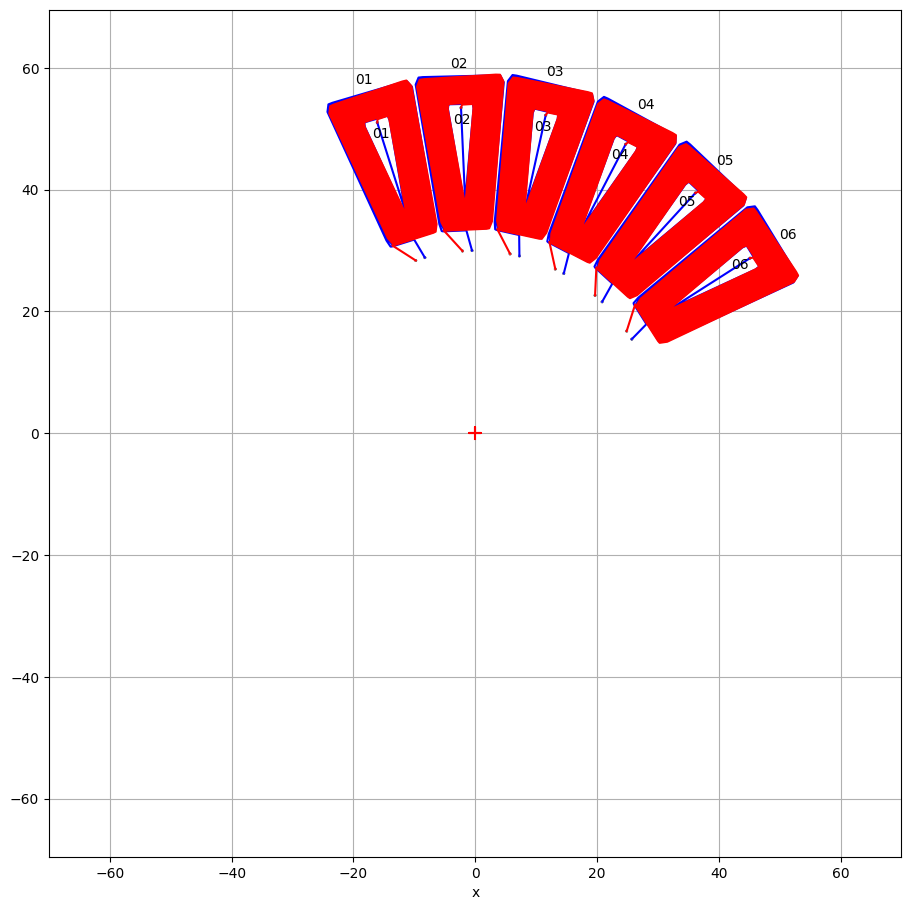

In [190]:
plot_json(json_result, 70)
# plot_json(json_result, 45)
print(json_result['parameters'])

print(TURNS)
print(f"Effective radius range: {radius_coil_start_effective} - {radius_coil_end_effective}")